In [610]:
!pip install ipywidgets<7
!pip install IPython<6
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

The system cannot find the file specified.
The system cannot find the file specified.
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [611]:
#Initialization
import nfldb
#there are some deprecation warnings that we don't want to print
import warnings
warnings.filterwarnings('ignore')

# import pandas and numpy for 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

# connect to PostgreSQL
import psycopg2
conn=psycopg2.connect("dbname='nfldb' user='postgres' host='localhost' password='Inhore@28' port=5432")

import ipywidgets as widgets
from ipywidgets import interactive, interact, interact_manual
from IPython.display import Image, display, HTML
%matplotlib inline

In [612]:
weather = pd.read_csv('data/weather.csv', sep="\t")

In [613]:
team_salary_cap =pd.read_csv('data/salary_cap.csv', sep="\t")

In [614]:
team_cash_payroll = pd.read_csv('data/cash_payroll.csv', sep="\t")

In [615]:
positional_spending = pd.read_csv('data/position_spending.csv', sep="\t")

In [616]:
weather['Temp_F'] = weather['Temp_F'].str.split("/", n = 1, expand = True)

In [617]:
#Domes will get the NaN value
weather['Temp_F'] = np.where((weather['Temp_F'].str.contains('DOME', regex=False)) , 70 ,  weather['Temp_F'])

In [618]:
weather['Away Score'] = np.where((weather['Away Score'].str.contains('-', regex=False)) , 10 ,  weather['Away Score'])

In [619]:
weather['Away Score'] = np.where((weather['Away Score'].str.contains('Q4: 17', regex=False)) , 17 ,  weather['Away Score'])

In [620]:
weather['Home Score'] = np.where((weather['Home Score'] == np.nan) , 36 ,  weather['Home Score'])

In [621]:
weather['Home Score'].fillna(0, inplace=True)

In [622]:
weather['Away Score'] = weather['Away Score'].astype(int)
weather['Home Score'] = weather['Home Score'].astype(int)
weather['Temp_F'] = weather['Temp_F'].astype(int)

In [623]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2559 entries, 0 to 2558
Data columns (total 11 columns):
0              2559 non-null object
Away Team      2559 non-null object
Home Team      2559 non-null object
Station        1792 non-null object
Temp_F         2559 non-null int32
Condition      1791 non-null object
Wind           1786 non-null object
Year           2559 non-null int64
Condition_2    2039 non-null object
Away Score     2559 non-null int32
Home Score     2559 non-null int32
dtypes: int32(3), int64(1), object(7)
memory usage: 190.0+ KB


In [624]:
team_salary_cap.loc[team_salary_cap['Team'] == "New York Jets", 'ABV'] = 'NYJ'
team_salary_cap.loc[team_salary_cap['Team'] == "Los Angeles Chargers", 'ABV'] = 'SD'
team_salary_cap.loc[team_salary_cap['Team'] == "San Diego Chargers",'ABV'] = 'SD'
team_salary_cap.loc[team_salary_cap['Team'] == "Kansas City Chiefs",'ABV'] = 'KC'
team_salary_cap.loc[team_salary_cap['Team'] == "Green Bay Packers",'ABV'] = 'GB'
team_salary_cap.loc[team_salary_cap['Team'] == "New York Giants",'ABV'] = 'NYG'
team_salary_cap.loc[team_salary_cap['Team'] == "New Orleans Saints",'ABV'] = 'NO'
team_salary_cap.loc[team_salary_cap['Team'] == "Los Angeles Rams",'ABV'] = 'STL'
team_salary_cap.loc[team_salary_cap['Team'] == "St. Louis Rams",'ABV'] = 'STL'
team_salary_cap.loc[team_salary_cap['Team'] == "New England Patriots",'ABV'] = 'NE'
team_salary_cap.loc[team_salary_cap['Team'] == "Tampa Bay Buccaneers",'ABV'] = 'TB'

In [625]:
team_salary_cap = team_salary_cap[team_salary_cap['Team'] != 'Houston Oilers']

In [626]:
unique_team_list = team_salary_cap.groupby(['Team', 'ABV']).size().reset_index(name='Freq')

In [627]:
team_split = unique_team_list['Team'].str.rsplit(' ', 1 ,expand=True).rename(columns=lambda x: 'col{}'.format(x + 1))

In [628]:
unique_team_list['Place'] = team_split['col1']
unique_team_list['Team'] = team_split['col2']

In [629]:
unique_team_list= unique_team_list.drop(['Place', 'Freq'], axis = 1)

In [630]:
aggregation_functions = {'ABV': 'first'}

In [631]:
unique_team_list = unique_team_list.groupby(unique_team_list['Team']).aggregate(aggregation_functions)

In [632]:
unique_team_list_2 = team_salary_cap.groupby(['Team', 'ABV','Year']).size().reset_index(name='Freq')

In [633]:
weather = weather.merge(unique_team_list, how='left', left_on ='Away Team', right_on='Team')

In [634]:
weather = weather.rename(columns ={'ABV' : 'Away ABV'})

In [635]:
weather = weather.merge(unique_team_list, how='left', left_on ='Home Team', right_on='Team')

In [636]:
weather = weather.rename(columns ={'ABV' : 'Home ABV'})

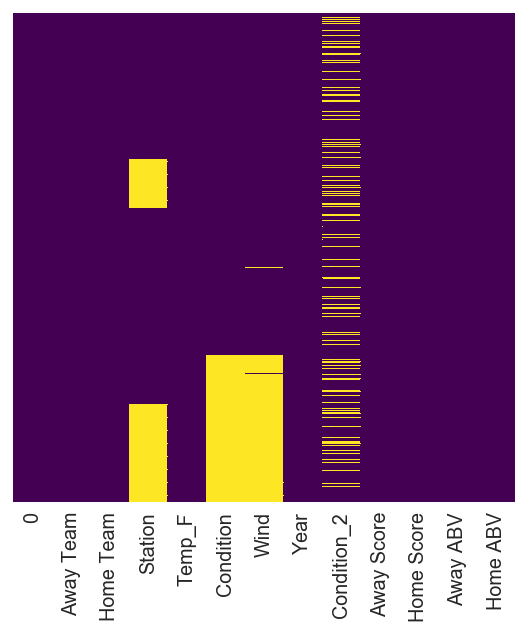

In [637]:
sns.set(rc={'figure.figsize':(9,9)}, font_scale=3)
sns.set(font_scale=1.8)
sns.heatmap(weather.isnull(),yticklabels=False, cbar=False,cmap='viridis')

In [638]:
weather.loc[(weather['Condition_2'].str.contains('shower', regex=False, na=False)) | (weather['Condition_2'].str.contains('Shower', regex=False, na=False)), 'Condition_2'] = 'rain'
weather.loc[(weather['Condition_2'].str.contains('sunny', regex=False, na=False)) | (weather['Condition_2'].str.contains('Sunny', regex=False, na=False)), 'Condition_2'] = 'sunny'
weather.loc[(weather['Condition_2'].str.contains('rain', regex=False, na=False)) | (weather['Condition_2'].str.contains('Rain', regex=False, na=False)) | (weather['Condition_2'].str.contains('drizzle', regex=False, na=False)) | (weather['Condition_2'].str.contains('Drizzle', regex=False, na=False)) | (weather['Condition_2'].str.contains('thunderstorm', regex=False, na=False)) | (weather['Condition_2'].str.contains('sprinkle', regex=False, na=False)) |  (weather['Condition_2'].str.contains('Thunderstorm', regex=False, na=False)), 'Condition_2'] = 'rain'
weather.loc[(weather['Condition_2'].str.contains('Fog', regex=False, na=False)) | (weather['Condition_2'].str.contains('fog', regex=False, na=False)) | (weather['Condition_2'].str.contains('Foggy', regex=False, na=False)) | (weather['Condition_2'].str.contains('foggy', regex=False, na=False)), 'Condition_2'] = 'fog'
weather.loc[(weather['Condition_2'].str.contains('clear', regex=False, na=False)) | (weather['Condition_2'].str.contains('Clear', regex=False, na=False)) | (weather['Condition_2'].str.contains('Dry', regex=False, na=False)) | (weather['Condition_2'].str.contains('dry', regex=False, na=False)) |  (weather['Condition_2'].str.contains('Fair', regex=False, na=False)), 'Condition_2'] = 'clear'
weather.loc[(weather['Condition_2'].str.contains('snow', regex=False, na=False)) | (weather['Condition_2'].str.contains('Snow', regex=False, na=False)) | (weather['Condition_2'].str.contains('flurries', regex=False, na=False)) | (weather['Condition_2'].str.contains('Flurries', regex=False, na=False)) | (weather['Condition_2'].str.contains('frost', regex=False, na=False)) |  (weather['Condition_2'].str.contains('Blizzard', regex=False, na=False)) | (weather['Condition_2'].str.contains('Wintry', regex=False, na=False)), 'Condition_2'] = 'snow'
weather.loc[(weather['Condition_2'].str.contains('cloudy', regex=False, na=False)) | (weather['Condition_2'].str.contains('Cloudy', regex=False, na=False)) | (weather['Condition_2'].str.contains('Overcast', regex=False, na=False)) | (weather['Condition_2'].str.contains('clouds', regex=False, na=False))| (weather['Condition_2'].str.contains('Clouds', regex=False, na=False)), 'Condition_2'] = 'cloudy'
weather.loc[(weather['Condition_2'].str.contains('Humid', regex=False, na=False)) | (weather['Condition_2'].str.contains('humid', regex=False, na=False)), 'Condition_2'] = 'humid'
weather.loc[(weather['Condition_2'].str.contains('Breezy', regex=False, na=False)), 'Condition_2'] = 'windy'
weather.loc[(weather['Condition_2'].isnull()), 'Condition_2'] = 'Dome'

In [639]:
condition_merge = pd.get_dummies(weather['Condition_2'])

In [640]:
condition_merge.drop(["NA              "], axis = 1, inplace=True)

In [641]:
weather =  pd.concat([weather, condition_merge], axis =1)

In [642]:
positional_spending['QB $ Per Game'] = positional_spending['QB']/16
positional_spending['RB/FB $ Per Game'] = positional_spending['RB_FB']/16
positional_spending['WR $ Per Game'] = positional_spending['WR']/16
positional_spending['TE $ Per Game'] = positional_spending['TE']/16
positional_spending['OL $ Per Game'] = positional_spending['OL']/16
positional_spending['DL $ Per Game'] = positional_spending['DL']/16
positional_spending['LB $ Per Game'] = positional_spending['LB']/16
positional_spending['DB $ Per Game'] = positional_spending['DB']/16
positional_spending['K/P/LS $ Per Game'] = positional_spending['K_P_LS']/16

In [643]:
positional_spending = positional_spending.merge(unique_team_list_2, how='left', left_on =['0','Year'], right_on=['Team','Year'])

In [644]:
positional_spending = positional_spending[positional_spending['Year'] != 2019]
positional_spending.drop(['0','Freq', 'Unnamed: 0'], axis =1, inplace = True)
t_col_move = positional_spending['Team']
positional_spending.drop(labels=['Team'], axis=1,inplace = True)
positional_spending.insert(0, 'Team', t_col_move)

In [645]:
# query game results
game_results=pd.read_sql("""select season_year, week, home_team, home_score, away_team, away_score
from game
where season_type='Regular'""",con=conn)

# replace la with stl
game_results.replace(to_replace='LA', value='STL', inplace=True)
game_results.replace(to_replace='UNK', value='SD', inplace=True)

# compute wins and ties
game_results['home_win'] = [1 if x>y else 0 for x,y in zip(game_results['home_score'],game_results['away_score'])]
game_results['away_win'] = [1 if x<y else 0 for x,y in zip(game_results['home_score'],game_results['away_score'])]
game_results['tie'] = [1 if x==y else 0 for x,y in zip(game_results['home_score'],game_results['away_score'])]

# sort the dataframe
game_results=game_results.sort_values(by=['season_year','home_team','week'])

# rename the year
game_results=game_results.rename(columns = {'season_year':'year'})

# print first 10 entries
game_results.head(10)

,year,week,home_team,home_score,away_team,away_score,home_win,away_win,tie
864,2009,1,ARI,16,SF,20,0,1,0
153,2009,3,ARI,10,IND,31,0,1,0
250,2009,5,ARI,28,HOU,21,1,0,0
727,2009,8,ARI,21,CAR,34,0,1,0
281,2009,10,ARI,31,SEA,20,1,0,0
829,2009,13,ARI,30,MIN,17,1,0,0
917,2009,16,ARI,31,STL,10,1,0,0
361,2009,17,ARI,7,GB,33,0,1,0
860,2009,1,ATL,19,MIA,7,1,0,0
1115,2009,2,ATL,28,CAR,20,1,0,0


In [646]:
game_results.tail(10)

,year,week,home_team,home_score,away_team,away_score,home_win,away_win,tie
2528,2018,16,TEN,25,WAS,16,1,0,0
2555,2018,17,TEN,17,IND,33,0,1,0
2329,2018,2,WAS,9,IND,21,0,1,0
2346,2018,3,WAS,31,GB,17,1,0,0
2391,2018,6,WAS,23,CAR,17,1,0,0
2408,2018,7,WAS,20,DAL,17,1,0,0
2432,2018,9,WAS,14,ATL,38,0,1,0
2459,2018,11,WAS,21,HOU,23,0,1,0
2505,2018,14,WAS,16,NYG,40,0,1,0
2556,2018,17,WAS,0,PHI,24,0,1,0


In [647]:
game_results = game_results.merge(weather, left_on = ['year','home_team', 'away_team','home_score','away_score'], right_on=['Year','Home ABV','Away ABV', 'Home Score','Away Score'])
game_results.drop(['0','Away Team', 'Home Team', 'Station', 'Condition', 'Wind', 'Year','Away Score','Home Score', 'Away ABV', 'Home ABV'], axis = 1, inplace = True)

In [648]:
game_results = game_results.merge(positional_spending, left_on = ['year','away_team'], right_on=['Year', 'ABV']).rename(columns = {'QB $ Per Game': 'QB $/Game_away','RB/FB $ Per Game': 'RB/FB $/Game_away','WR $ Per Game': 'WR $/Game_away','TE $ Per Game': 'TE $/Game_away','OL $ Per Game': 'OL $/Game_away','DL $ Per Game': 'DL $/Game_away','DB $ Per Game': 'DB $/Game_away', 'K/P/LS $ Per Game': 'K/P/LS $/Game_away', 'LB $ Per Game': 'LB $/Game_away' })
game_results.drop(['Year','Team','Players','QB','RB_FB','WR','TE','OL','DL','LB','DB','K_P_LS','Total','ABV'], axis = 1, inplace = True)

In [649]:
game_results = game_results.merge(positional_spending, left_on = ['year','home_team'], right_on=['Year', 'ABV']).rename(columns = {'QB $ Per Game': 'QB $/Game_home','RB/FB $ Per Game': 'RB/FB $/Game_home','WR $ Per Game': 'WR $/Game_home','TE $ Per Game': 'TE $/Game_home','OL $ Per Game': 'OL $/Game_home','DL $ Per Game': 'DL $/Game_home','DB $ Per Game': 'DB $/Game_home', 'K/P/LS $ Per Game': 'K/P/LS $/Game_home','LB $ Per Game': 'LB $/Game_home' })
game_results.drop(['Year','Team','Players','QB','RB_FB','WR','TE','OL','DL','LB','DB','K_P_LS','Total','ABV'], axis = 1, inplace = True)

In [650]:
game_results = game_results.merge(team_salary_cap[['AVG Age','Year','ABV']],left_on=['year','away_team'], right_on=['Year','ABV']).rename(columns= {'AVG Age': 'Avg. Age_away'})
game_results.drop(['Year','ABV'], axis = 1, inplace = True)

In [651]:
game_results = game_results.merge(team_salary_cap[['AVG Age','Year','ABV']],left_on=['year','home_team'], right_on=['Year','ABV']).rename(columns= {'AVG Age': 'Avg. Age_home'})
game_results.drop(['Year','ABV', 'Condition_2'], axis = 1, inplace = True)

In [652]:
game_results['QB $_diff'] = game_results['QB $/Game_home'] - game_results['QB $/Game_away']
game_results['RB/FB $_diff'] = game_results['RB/FB $/Game_home'] - game_results['RB/FB $/Game_away']
game_results['WR $_diff'] = game_results['WR $/Game_home'] - game_results['WR $/Game_away']
game_results['TE $_diff'] = game_results['TE $/Game_home'] - game_results['TE $/Game_away']
game_results['OL $_diff'] = game_results['OL $/Game_home'] - game_results['OL $/Game_away']
game_results['DL $_diff'] = game_results['DL $/Game_home'] - game_results['DL $/Game_away']
game_results['LB $_diff'] = game_results['LB $/Game_home'] - game_results['LB $/Game_away']
game_results['DB $_diff'] = game_results['DB $/Game_home'] - game_results['DB $/Game_away']
game_results['K/P/LS $_diff'] = game_results['K/P/LS $/Game_home'] - game_results['K/P/LS $/Game_away']
game_results['Avg. Age_diff'] = game_results['Avg. Age_home'] - game_results['Avg. Age_away']

In [653]:
game_results.tail()

,year,week,home_team,home_score,away_team,away_score,home_win,away_win,tie,Temp_F,...,QB $_diff,RB/FB $_diff,WR $_diff,TE $_diff,OL $_diff,DL $_diff,LB $_diff,DB $_diff,K/P/LS $_diff,Avg. Age_diff
2552,2018,13,NE,24,MIN,10,1,0,0,51,...,-2.216875e+05,36330.1875,-84056.6875,365640.8750,-341805.0625,-1.228295e+06,-1.869574e+05,3.117158e+05,289375.0000,1.50
2553,2018,4,NE,38,MIA,7,1,0,0,66,...,7.998959e+05,353606.1250,-371127.5625,755884.3125,-42011.6875,-1.326506e+06,1.067762e+05,1.356677e+06,385679.1875,1.25
2554,2018,9,NE,31,GB,17,1,0,0,42,...,5.269200e+04,478381.5000,-722575.8750,281106.8125,-892333.7500,8.989636e+05,3.038619e+04,1.751834e+06,98517.3125,2.10
2555,2018,16,NE,24,BUF,12,1,0,0,37,...,1.121379e+06,-300977.9375,691145.2500,289210.9375,367050.4375,-9.620651e+05,4.534702e+05,1.320781e+06,257481.6250,1.10
2556,2018,6,NE,43,KC,40,1,0,0,45,...,1.036366e+06,149244.1250,109311.3750,146347.8750,-673445.6875,1.418199e+05,-1.286141e+06,8.188676e+05,298437.5000,1.50


In [654]:
game_results.describe()

,year,week,home_score,away_score,home_win,away_win,tie,Temp_F,Dome,clear,...,QB $_diff,RB/FB $_diff,WR $_diff,TE $_diff,OL $_diff,DL $_diff,LB $_diff,DB $_diff,K/P/LS $_diff,Avg. Age_diff
count,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,...,2.557000e+03,2557.000000,2.557000e+03,2557.000000,2.557000e+03,2.557000e+03,2.557000e+03,2.557000e+03,2557.000000,2557.000000
mean,2013.504889,9.072350,23.723504,21.294486,0.570591,0.426672,0.002738,61.340634,0.203363,0.279233,...,-4.677115e+02,273.677552,1.351402e+02,-164.639886,2.124951e+02,8.555504e+02,-9.439201e+02,1.717988e+02,125.542164,0.000747
std,2.870932,5.005225,10.420981,9.905525,0.495089,0.494691,0.052260,15.709938,0.402579,0.448710,...,5.909230e+05,322257.731448,5.231067e+05,271768.036921,5.526740e+05,7.808802e+05,6.164655e+05,6.108556e+05,154652.210980,0.727657
min,2009.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.670923e+06,-985933.750000,-1.656578e+06,-954736.625000,-1.946871e+06,-2.766678e+06,-2.206080e+06,-1.770830e+06,-581258.875000,-2.830000
25%,2011.000000,5.000000,17.000000,14.000000,0.000000,0.000000,0.000000,52.000000,0.000000,0.000000,...,-3.883409e+05,-209279.375000,-3.364276e+05,-177894.062500,-3.795454e+05,-4.942438e+05,-3.976164e+05,-4.046145e+05,-96567.187500,-0.460000
50%,2014.000000,9.000000,23.000000,21.000000,1.000000,0.000000,0.000000,66.000000,0.000000,0.000000,...,-2.146750e+03,-234.750000,8.110000e+02,6335.187500,1.185094e+04,-3.533312e+03,-1.002312e+03,-5.546500e+03,-2395.812500,0.000000
75%,2016.000000,13.000000,31.000000,27.000000,1.000000,1.000000,0.000000,70.000000,0.000000,1.000000,...,3.804919e+05,206599.312500,3.322379e+05,179899.500000,3.817151e+05,5.074791e+05,4.031466e+05,4.043242e+05,96567.187500,0.480000
max,2018.000000,17.000000,62.000000,59.000000,1.000000,1.000000,1.000000,93.000000,1.000000,1.000000,...,1.670923e+06,997603.687500,1.744658e+06,958472.562500,1.946871e+06,2.587999e+06,1.979390e+06,1.771164e+06,556608.375000,2.460000


In [655]:
game_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2557 entries, 0 to 2556
Data columns (total 49 columns):
year                  2557 non-null int64
week                  2557 non-null int64
home_team             2557 non-null object
home_score            2557 non-null int64
away_team             2557 non-null object
away_score            2557 non-null int64
home_win              2557 non-null int64
away_win              2557 non-null int64
tie                   2557 non-null int64
Temp_F                2557 non-null int32
Dome                  2557 non-null uint8
clear                 2557 non-null uint8
cloudy                2557 non-null uint8
fog                   2557 non-null uint8
humid                 2557 non-null uint8
rain                  2557 non-null uint8
snow                  2557 non-null uint8
sunny                 2557 non-null uint8
windy                 2557 non-null uint8
QB $/Game_away        2557 non-null float64
RB/FB $/Game_away     2557 non-null float64
WR $/

In [656]:
# total number of games
total_games = len(game_results)
total_games

2557

In [657]:
# total number of home wins
home_wins = game_results.home_win.sum()
home_wins

1459

In [658]:
# total home wins/total number of games
home_win_rate = float(home_wins)/float(total_games)
home_win_rate

0.570590535784122

In [659]:
print("Home Team Win Rate: {:.2f}% ".format(home_win_rate*100))

Home Team Win Rate: 57.06% 


In [660]:
wins = game_results[['home_win','away_win', 'tie']]

In [661]:
wins.rename({'home_win':'Home Win','away_win':'Away Win','tie':'Tie'}, axis = 'columns',inplace = True)

In [662]:
wins_2 = wins.apply(pd.value_counts)

In [663]:
wins_2

,Home Win,Away Win,Tie
0,1098,1466,2550
1,1459,1091,7


Text(0,0.5,'Count')

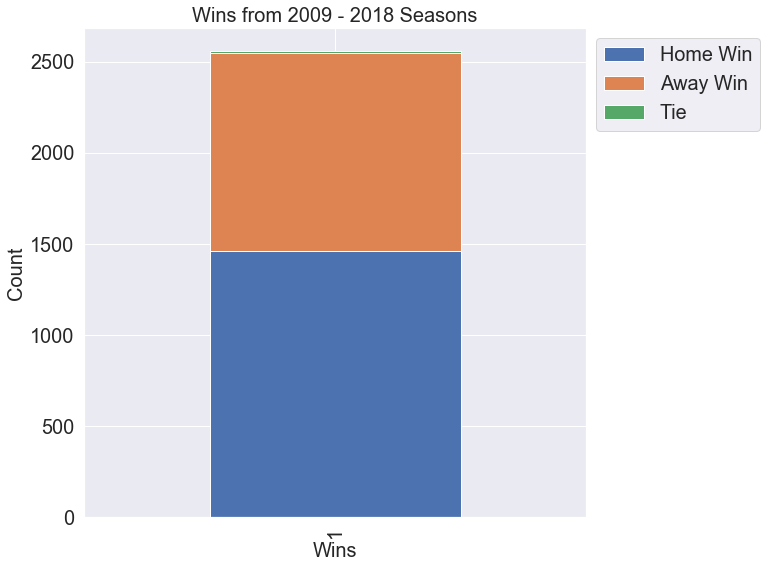

In [664]:
wins_2.loc[[1]].plot(kind='bar', stacked=True).legend(bbox_to_anchor=(1.0, 1))
plt.title('Wins from 2009 - 2018 Seasons', fontsize=20)
plt.xlabel('Wins', fontsize=20)
plt.ylabel('Count', fontsize=20)

In [665]:
game_home_win = game_results[['home_team','year','home_win']]
game_home_win['game_home_win_cum_sum'] = (game_home_win['home_win'] == 1 )*1
game_home_win['Cumulative Win'] = game_home_win.groupby(['home_team', 'year']).game_home_win_cum_sum.cumsum()
game_home_win.drop(columns=['home_win','game_home_win_cum_sum'], inplace = True)

In [666]:
game_home_win = game_home_win[game_home_win['Cumulative Win'] ==  game_home_win.groupby(['home_team', 'year'])['Cumulative Win'].transform('max')]

In [667]:
game_home_win.drop_duplicates(inplace=True)

In [668]:
game_home_win.head()

,home_team,year,Cumulative Win
6,ARI,2009,4
15,GB,2009,6
21,HOU,2009,4
30,IND,2009,6
38,MIN,2009,8


In [669]:
stats=pd.read_sql("""select drive.pos_team, drive.drive_id, drive.pos_time, drive.first_downs, drive.yards_gained, drive.play_count, drive.result, game.season_year, game.week, game.season_type, game.home_team, game.away_team
from drive
inner join game on drive.gsis_id=game.gsis_id
where season_type='Regular'""",con=conn)

#replace la with stl
stats.replace(to_replace='LA', value='STL', inplace=True)
stats.replace(to_replace='LAC', value='SD', inplace=True)
stats.replace(to_replace='UNK', value='SD', inplace=True)

# encode points results
stats['points'] = [3 if x=="Field Goal" else 7 if x=="Touchdown" else 0 for x in stats['result']]

# encode turnover results
stats['turnover'] = [1 if x==("Interception" or "Fumble" or "Safety" or "Blocked FG" or "Fumble, Safety" or "Blocked Punt" or "Blocked Punt, Downs" or "Blocked FG, Downs") else 0 for x in stats['result']]

# look at the table
stats.head(26)


,pos_team,drive_id,pos_time,first_downs,yards_gained,play_count,result,season_year,week,season_type,home_team,away_team,points,turnover
0,MIA,16,(2),0,0,2,End of Half,2009,7,Regular,MIA,NO,0,0
1,PIT,1,(104),0,2,5,Punt,2009,1,Regular,PIT,TEN,0,0
2,TEN,2,(112),0,2,4,Punt,2009,1,Regular,PIT,TEN,0,0
3,PIT,3,(184),1,2,6,Punt,2009,1,Regular,PIT,TEN,0,0
4,TEN,4,(96),3,55,6,Missed FG,2009,1,Regular,PIT,TEN,0,0
5,PIT,5,(115),0,-6,4,Punt,2009,1,Regular,PIT,TEN,0,0
6,TEN,6,(191),2,35,7,Interception,2009,1,Regular,PIT,TEN,0,1
7,PIT,7,(92),0,3,3,Interception,2009,1,Regular,PIT,TEN,0,1
8,TEN,8,(122),1,0,7,Punt,2009,1,Regular,PIT,TEN,0,0
9,PIT,9,(350),2,53,11,Punt,2009,1,Regular,PIT,TEN,0,0


In [670]:
stats.tail()

,pos_team,drive_id,pos_time,first_downs,yards_gained,play_count,result,season_year,week,season_type,home_team,away_team,points,turnover
59914,OAK,17,(103),0,5,6,Punt,2018,16,Regular,OAK,DEN,0,0
59915,DEN,18,(12),0,0,2,Interception,2018,16,Regular,OAK,DEN,0,1
59916,OAK,19,(58),0,4,6,Field Goal,2018,16,Regular,OAK,DEN,3,0
59917,DEN,20,(56),0,6,7,Interception,2018,16,Regular,OAK,DEN,0,1
59918,OAK,21,(222),1,10,8,End of Game,2018,16,Regular,OAK,DEN,0,0


In [671]:
#add next weeks stats
games_18 = game_results[game_results['year']==2018]

nweek = pd.DataFrame({
        'year': np.array([2018] * 32,dtype='int32'),
        'week': np.array([1] * 32,dtype='int32'),
        'team': np.array((list(set(stats.pos_team))),dtype=str)})

nweek_d = nweek
nweek_o = nweek

In [672]:
# defense
stats_d = stats
stats_d['opp_team'] = np.where(stats_d['pos_team']==stats_d['home_team'], stats_d['away_team'], stats_d['home_team'])
#subset to defensive stats
stats_d = stats_d[['season_year','week','opp_team','yards_gained','points','turnover']]
# rename columns
stats_d.columns = ['year','week','team','yards_allowed','points_allowed','turnovers_forced']

#add next week
stats_d = stats_d.append(nweek_d)

# aggregate rolling 5 week
## sort at year, team, week
stats_d.sort_values(by=['team','year','week'],inplace=True)
## sum across year team week
stats_d=stats_d.groupby(by=['team','year','week'],as_index=False).sum()
## rolling 5 week lagged
rolling = stats_d.groupby(['team'],as_index=False)['yards_allowed','points_allowed','turnovers_forced'].rolling(5).sum().shift(1).reset_index()
## join together
stats_d=stats_d.join(rolling,lsuffix='_weekly',rsuffix='_rolling')

stats_d.head()

,team,year,week,points_allowed_weekly,turnovers_forced_weekly,yards_allowed_weekly,level_0,level_1,yards_allowed_rolling,points_allowed_rolling,turnovers_forced_rolling
0,ARI,2009,1,20.0,0.0,203.0,0,0,NaN,NaN,NaN
1,ARI,2009,2,17.0,1.0,367.0,0,1,NaN,NaN,NaN
2,ARI,2009,3,31.0,1.0,501.0,0,2,NaN,NaN,NaN
3,ARI,2009,5,21.0,1.0,414.0,0,3,NaN,NaN,NaN
4,ARI,2009,6,3.0,1.0,128.0,0,4,NaN,NaN,NaN


In [673]:
stats_d.tail()

,team,year,week,points_allowed_weekly,turnovers_forced_weekly,yards_allowed_weekly,level_0,level_1,yards_allowed_rolling,points_allowed_rolling,turnovers_forced_rolling
5115,WAS,2018,13,27.0,1.0,436.0,31,5115,2010.0,101.0,7.0
5116,WAS,2018,14,34.0,1.0,402.0,31,5116,2143.0,115.0,6.0
5117,WAS,2018,15,6.0,1.0,192.0,31,5117,2054.0,111.0,6.0
5118,WAS,2018,16,20.0,0.0,291.0,31,5118,1754.0,114.0,5.0
5119,WAS,2018,17,24.0,1.0,360.0,31,5119,1725.0,118.0,3.0


In [674]:
# offense
stats_o = stats
stats_o=stats_o.rename(columns = {'pos_team':'team'})
stats_o=stats_o.rename(columns = {'season_year':'year'})
stats_o = stats_o[['team','year','week','first_downs','yards_gained','play_count','points','turnover']]

#add next week
stats_o = stats_o.append(nweek_o)

# aggregate rolling 5 week
## sort at year, team, week
stats_o.sort_values(by=['team','year','week'],inplace=True)
## sum across year team week
stats_o=stats_o.groupby(by=['team','year','week'],as_index=False).sum()
## rolling 5 week lagged
rolling = stats_o.groupby(['team'],as_index=False)['first_downs','yards_gained','play_count','points','turnover'].rolling(5).sum().shift(1).reset_index()
## join together
stats_o=stats_o.join(rolling,lsuffix='_weekly',rsuffix='_rolling')

stats_o.head(10)

,team,year,week,first_downs_weekly,play_count_weekly,points_weekly,turnover_weekly,yards_gained_weekly,level_0,level_1,first_downs_rolling,yards_gained_rolling,play_count_rolling,points_rolling,turnover_rolling
0,ARI,2009,1,17.0,99.0,16.0,2.0,299.0,0,0,NaN,NaN,NaN,NaN,NaN
1,ARI,2009,2,22.0,89.0,24.0,0.0,388.0,0,1,NaN,NaN,NaN,NaN,NaN
2,ARI,2009,3,21.0,97.0,10.0,2.0,317.0,0,2,NaN,NaN,NaN,NaN,NaN
3,ARI,2009,5,19.0,81.0,21.0,0.0,340.0,0,3,NaN,NaN,NaN,NaN,NaN
4,ARI,2009,6,21.0,100.0,27.0,1.0,344.0,0,4,NaN,NaN,NaN,NaN,NaN
5,ARI,2009,7,15.0,88.0,24.0,1.0,288.0,0,5,100.0,1688.0,466.0,98.0,5.0
6,ARI,2009,8,23.0,91.0,21.0,5.0,320.0,0,6,98.0,1677.0,455.0,106.0,4.0
7,ARI,2009,9,27.0,91.0,41.0,1.0,438.0,0,7,99.0,1609.0,457.0,103.0,9.0
8,ARI,2009,10,22.0,98.0,31.0,0.0,462.0,0,8,105.0,1730.0,451.0,134.0,8.0
9,ARI,2009,11,24.0,90.0,21.0,0.0,442.0,0,9,108.0,1852.0,468.0,144.0,8.0


In [675]:
# drop the level variables from offense and defensive
stats_o = stats_o.drop(['level_0','level_1'], axis=1)
stats_d = stats_d.drop(['level_0','level_1'], axis=1)

# combine offense and defense stats
stats_od=pd.merge(stats_d,stats_o,how='inner',on=['team','year','week'])

# drop the year 2009 becasue of the blank weeks
stats_od=stats_od[stats_od['year']!=2009]

# drop the weekly stats because we won't be needing them
weekly_stats = [col for col in stats_od if col.endswith('weekly')]
stats_od = stats_od.drop(weekly_stats, axis=1)

# convert to numeric
stats_od=stats_od.apply(pd.to_numeric, errors='ignore')

In [676]:
stats_o.head(10)

,team,year,week,first_downs_weekly,play_count_weekly,points_weekly,turnover_weekly,yards_gained_weekly,first_downs_rolling,yards_gained_rolling,play_count_rolling,points_rolling,turnover_rolling
0,ARI,2009,1,17.0,99.0,16.0,2.0,299.0,NaN,NaN,NaN,NaN,NaN
1,ARI,2009,2,22.0,89.0,24.0,0.0,388.0,NaN,NaN,NaN,NaN,NaN
2,ARI,2009,3,21.0,97.0,10.0,2.0,317.0,NaN,NaN,NaN,NaN,NaN
3,ARI,2009,5,19.0,81.0,21.0,0.0,340.0,NaN,NaN,NaN,NaN,NaN
4,ARI,2009,6,21.0,100.0,27.0,1.0,344.0,NaN,NaN,NaN,NaN,NaN
5,ARI,2009,7,15.0,88.0,24.0,1.0,288.0,100.0,1688.0,466.0,98.0,5.0
6,ARI,2009,8,23.0,91.0,21.0,5.0,320.0,98.0,1677.0,455.0,106.0,4.0
7,ARI,2009,9,27.0,91.0,41.0,1.0,438.0,99.0,1609.0,457.0,103.0,9.0
8,ARI,2009,10,22.0,98.0,31.0,0.0,462.0,105.0,1730.0,451.0,134.0,8.0
9,ARI,2009,11,24.0,90.0,21.0,0.0,442.0,108.0,1852.0,468.0,144.0,8.0


In [677]:
mean_stat_o = stats_o.groupby(['team', 'year'])['first_downs_weekly','play_count_weekly', 'points_weekly', 'yards_gained_weekly'].mean().reset_index()

In [678]:
mean_stat_o

,team,year,first_downs_weekly,play_count_weekly,points_weekly,yards_gained_weekly
0,ARI,2009,19.8125,87.4375,22.6250,343.3750
1,ARI,2010,15.0625,81.9375,14.5625,268.5000
2,ARI,2011,17.8750,85.1875,18.0000,323.0000
3,ARI,2012,15.3750,87.5000,13.8750,262.6250
4,ARI,2013,20.5625,87.7500,21.3750,345.9375
5,ARI,2014,18.8750,88.4375,17.2500,319.8750
6,ARI,2015,23.3125,90.8750,28.0000,407.9375
7,ARI,2016,23.0000,95.6875,24.9375,362.4375
8,ARI,2017,19.3750,92.3750,17.8125,314.3750
9,ARI,2018,14.9375,80.1875,12.7500,241.1875


In [679]:
stats_d.head(10)

,team,year,week,points_allowed_weekly,turnovers_forced_weekly,yards_allowed_weekly,yards_allowed_rolling,points_allowed_rolling,turnovers_forced_rolling
0,ARI,2009,1,20.0,0.0,203.0,NaN,NaN,NaN
1,ARI,2009,2,17.0,1.0,367.0,NaN,NaN,NaN
2,ARI,2009,3,31.0,1.0,501.0,NaN,NaN,NaN
3,ARI,2009,5,21.0,1.0,414.0,NaN,NaN,NaN
4,ARI,2009,6,3.0,1.0,128.0,NaN,NaN,NaN
5,ARI,2009,7,17.0,3.0,327.0,1613.0,92.0,4.0
6,ARI,2009,8,27.0,0.0,355.0,1737.0,89.0,7.0
7,ARI,2009,9,21.0,1.0,417.0,1725.0,99.0,6.0
8,ARI,2009,10,20.0,2.0,472.0,1641.0,89.0,6.0
9,ARI,2009,11,13.0,1.0,314.0,1699.0,88.0,7.0


In [680]:
mean_stat_d = stats_d.groupby(['team', 'year'])['points_allowed_weekly','turnovers_forced_weekly', 'yards_allowed_weekly'].mean().reset_index()

In [681]:
mean_stat_d.head()

,team,year,points_allowed_weekly,turnovers_forced_weekly,yards_allowed_weekly
0,ARI,2009,18.8750,1.3125,346.0625
1,ARI,2010,25.4375,1.0625,372.7500
2,ARI,2011,20.5625,0.6250,353.4375
3,ARI,2012,18.6875,1.3750,336.5625
4,ARI,2013,19.5625,1.2500,317.1875


In [682]:
mean_stat_d.head()

,team,year,points_allowed_weekly,turnovers_forced_weekly,yards_allowed_weekly
0,ARI,2009,18.8750,1.3125,346.0625
1,ARI,2010,25.4375,1.0625,372.7500
2,ARI,2011,20.5625,0.6250,353.4375
3,ARI,2012,18.6875,1.3750,336.5625
4,ARI,2013,19.5625,1.2500,317.1875


In [683]:
merge_stats = mean_stat_o.merge(mean_stat_d, on = ['team', 'year'])

In [684]:
merge_stats = merge_stats.merge(game_home_win, left_on=['team','year'], right_on = ['home_team','year'])

In [685]:
merge_stats.head()

,team,year,first_downs_weekly,play_count_weekly,points_weekly,yards_gained_weekly,points_allowed_weekly,turnovers_forced_weekly,yards_allowed_weekly,home_team,Cumulative Win
0,ARI,2009,19.8125,87.4375,22.6250,343.3750,18.8750,1.3125,346.0625,ARI,4
1,ARI,2010,15.0625,81.9375,14.5625,268.5000,25.4375,1.0625,372.7500,ARI,4
2,ARI,2011,17.8750,85.1875,18.0000,323.0000,20.5625,0.6250,353.4375,ARI,6
3,ARI,2012,15.3750,87.5000,13.8750,262.6250,18.6875,1.3750,336.5625,ARI,4
4,ARI,2013,20.5625,87.7500,21.3750,345.9375,19.5625,1.2500,317.1875,ARI,6


Text(0,0.5,'Average Weekly First Downs')

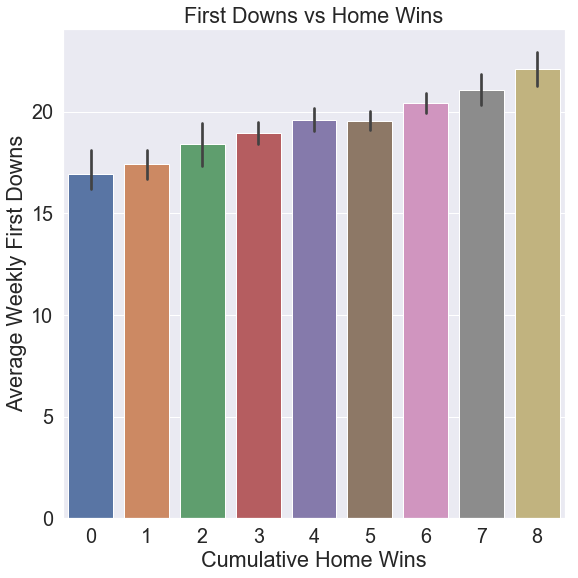

In [686]:
sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['first_downs_weekly']).set_title("First Downs vs Home Wins")
plt.xlabel('Cumulative Home Wins')
plt.ylabel('Average Weekly First Downs')

Text(0,0.5,'Average Weekly Yards Allowed')

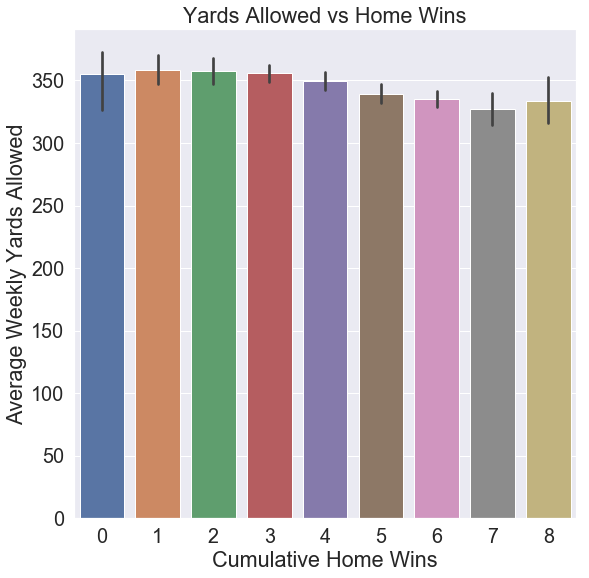

In [687]:
sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['yards_allowed_weekly']).set_title("Yards Allowed vs Home Wins")
plt.xlabel('Cumulative Home Wins')
plt.ylabel('Average Weekly Yards Allowed')

Text(0,0.5,'Average Weekly Yards Gained')

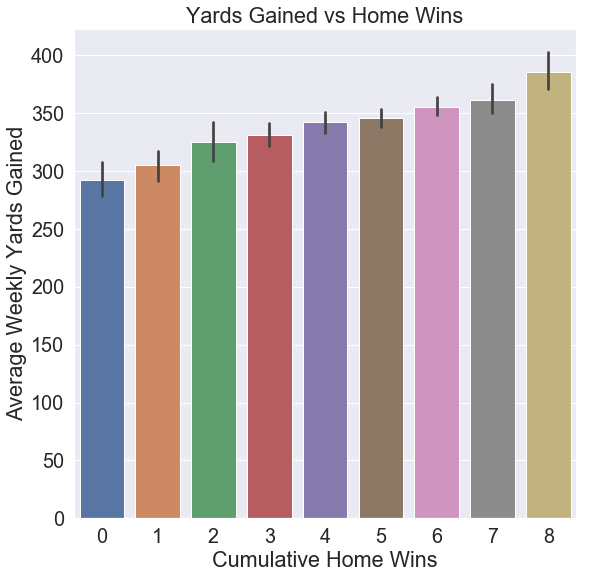

In [688]:
sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['yards_gained_weekly']).set_title("Yards Gained vs Home Wins")

plt.xlabel('Cumulative Home Wins')
plt.ylabel('Average Weekly Yards Gained')

Text(0,0.5,'Average Weekly Play Count')

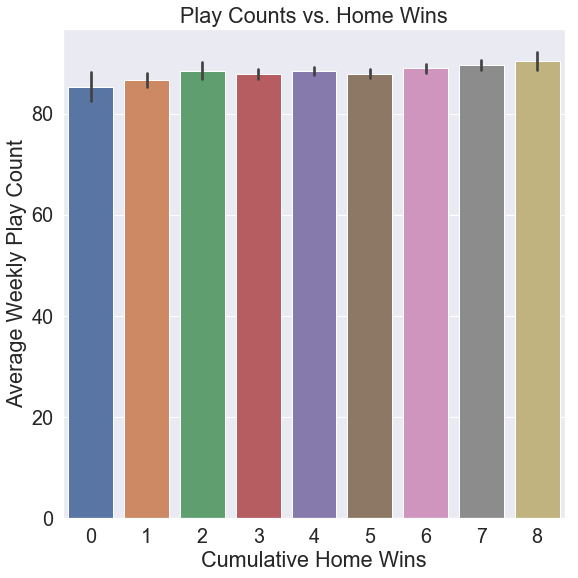

In [689]:
sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['play_count_weekly']).set_title("Play Counts vs. Home Wins")

plt.xlabel('Cumulative Home Wins')
plt.ylabel('Average Weekly Play Count')


Text(0,0.5,'Average Weekly Points Allowed')

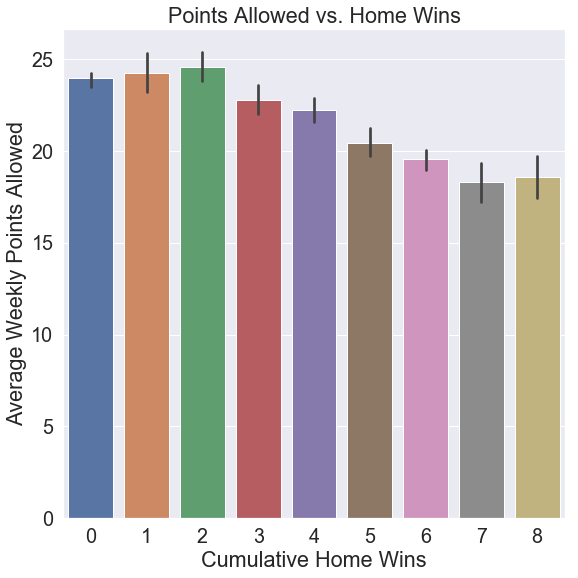

In [690]:
sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['points_allowed_weekly']).set_title("Points Allowed vs. Home Wins")

plt.xlabel('Cumulative Home Wins')
plt.ylabel('Average Weekly Points Allowed')


Text(0,0.5,'Average Weekly Points')

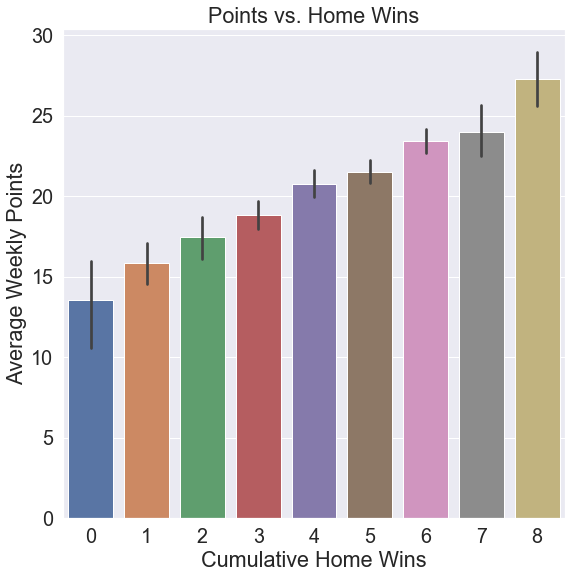

In [691]:
sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['points_weekly']).set_title("Points vs. Home Wins")

plt.xlabel('Cumulative Home Wins')
plt.ylabel('Average Weekly Points')

Text(0,0.5,'Average Weekly Forced Turnovers')

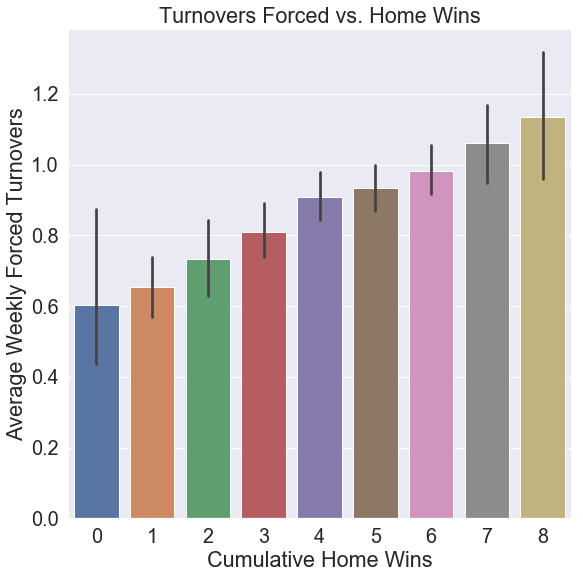

In [692]:
sns.barplot(x=merge_stats['Cumulative Win'], y = merge_stats['turnovers_forced_weekly']).set_title("Turnovers Forced vs. Home Wins")

plt.xlabel('Cumulative Home Wins')
plt.ylabel('Average Weekly Forced Turnovers')

In [693]:
stats_od.head(10)

,team,year,week,yards_allowed_rolling,points_allowed_rolling,turnovers_forced_rolling,first_downs_rolling,yards_gained_rolling,play_count_rolling,points_rolling,turnover_rolling
16,ARI,2010,1,1507.0,92.0,10.0,91.0,1577.0,404.0,109.0,6.0
17,ARI,2010,2,1517.0,88.0,11.0,92.0,1557.0,406.0,96.0,6.0
18,ARI,2010,3,1634.0,105.0,9.0,92.0,1579.0,406.0,93.0,7.0
19,ARI,2010,4,1709.0,111.0,8.0,89.0,1466.0,397.0,86.0,7.0
20,ARI,2010,5,1890.0,135.0,5.0,73.0,1183.0,369.0,58.0,9.0
21,ARI,2010,7,1903.0,131.0,7.0,72.0,1201.0,385.0,67.0,7.0
22,ARI,2010,8,1880.0,140.0,4.0,64.0,1050.0,374.0,60.0,8.0
23,ARI,2010,9,1843.0,123.0,4.0,75.0,1177.0,393.0,81.0,9.0
24,ARI,2010,10,1993.0,127.0,5.0,70.0,1175.0,392.0,74.0,8.0
25,ARI,2010,11,2064.0,129.0,6.0,79.0,1378.0,410.0,88.0,7.0


In [694]:
# create a new games dataframe from game_results
games = game_results

# rename columns
stats_od.columns=['team','year','week','yards_allowed','points_allowed','turnover_forced','first_downs','yards_gained','play_count','points','turnovers']

# merge game results with stats; there need to be two merges because both home and away teams need statistics
games=pd.merge(pd.merge(games,stats_od,left_on=['home_team','year','week'],right_on=['team','year','week']),stats_od,left_on=['away_team','year','week'],right_on=['team','year','week'],suffixes=['_home','_away'])

# comptue diffs for each variable
diffs=['yards_allowed','points_allowed','turnover_forced','first_downs','yards_gained','play_count','points','turnovers']
for i in diffs:
    diff_column = i + "_diff"
    home_column = i + "_home"
    away_column = i + "_away"
    games[diff_column] = games[home_column] - games[away_column]

# we only need the diffs, so drop all the home/away specific stats columns
home = [col for col in games if col.endswith('home')]
away = [col for col in games if col.endswith('away')]
games = games.drop(home,axis=1)
games = games.drop(away,axis=1)

In [695]:
games.head()

,year,week,home_team,home_score,away_team,away_score,home_win,away_win,tie,Temp_F,...,K/P/LS $_diff,Avg. Age_diff,yards_allowed_diff,points_allowed_diff,turnover_forced_diff,first_downs_diff,yards_gained_diff,play_count_diff,points_diff,turnovers_diff
0,2010,3,ARI,24,OAK,23,1,0,0,70,...,-378375.0000,0.32,130.0,-10.0,8.0,-15.0,-168.0,-68.0,22.0,-1.0
1,2010,5,ARI,30,NO,20,1,0,0,70,...,76630.1875,0.49,240.0,40.0,2.0,-23.0,-406.0,-70.0,-29.0,6.0
2,2010,8,ARI,35,TB,38,0,1,0,70,...,55625.0000,2.18,98.0,34.0,-4.0,-27.0,-512.0,-60.0,-16.0,6.0
3,2010,10,ARI,18,SEA,36,0,1,0,70,...,-121187.5000,0.34,83.0,10.0,3.0,1.0,-44.0,-50.0,18.0,4.0
4,2010,12,ARI,6,SF,27,0,1,0,70,...,-11250.0000,0.62,472.0,50.0,-1.0,8.0,-25.0,1.0,8.0,4.0


In [696]:
games.tail()

,year,week,home_team,home_score,away_team,away_score,home_win,away_win,tie,Temp_F,...,K/P/LS $_diff,Avg. Age_diff,yards_allowed_diff,points_allowed_diff,turnover_forced_diff,first_downs_diff,yards_gained_diff,play_count_diff,points_diff,turnovers_diff
2298,2018,13,NE,24,MIN,10,1,0,0,51,...,289375.0000,1.50,580.0,19.0,-2.0,12.0,296.0,28.0,-1.0,-3.0
2299,2018,4,NE,38,MIA,7,1,0,0,66,...,385679.1875,1.25,-50.0,-13.0,-4.0,24.0,-29.0,48.0,12.0,0.0
2300,2018,9,NE,31,GB,17,1,0,0,42,...,98517.3125,2.10,217.0,-11.0,4.0,13.0,-6.0,30.0,45.0,4.0
2301,2018,16,NE,24,BUF,12,1,0,0,37,...,257481.6250,1.10,521.0,16.0,-1.0,5.0,168.0,11.0,-14.0,-2.0
2302,2018,6,NE,43,KC,40,1,0,0,45,...,298437.5000,1.50,-490.0,-18.0,0.0,-17.0,-274.0,-24.0,-28.0,4.0


In [697]:
from sklearn.model_selection import train_test_split

# create past games df that will be used to train our model
past_games = games[(games['year']!=max(games.year)) & (games['week']!=max(games_18.week))]

# create future games df that will be predicted using our trained model
future_games = games[(games['year']==max(games.year)) ]

# for statsmodels, we need to specify
past_games['intercept'] = 1.0
future_games['intercept'] = 1.0

# our training columns will be the diffs
training_cols = [col for col in games if col.endswith('diff')] + ['Temp_F', 'Dome', 'clear', 'cloudy', 'fog', 'humid', 'rain', 'snow','sunny', 'windy']
# for correlation check
for_corr = training_cols + ["home_win"]



In [698]:
past_games[training_cols]

,QB $_diff,RB/FB $_diff,WR $_diff,TE $_diff,OL $_diff,DL $_diff,LB $_diff,DB $_diff,K/P/LS $_diff,Avg. Age_diff,...,Temp_F,Dome,clear,cloudy,fog,humid,rain,snow,sunny,windy
0,-2.808842e+05,-163302.1250,5.950266e+05,50453.1250,4.839971e+05,-8.846955e+05,-2.129008e+05,2.866728e+05,-378375.0000,0.32,...,70,1,0,0,0,0,0,0,0,0
1,-6.367842e+05,-682238.3125,1.584614e+05,-279064.6875,-1.484926e+05,5.444481e+04,-1.185138e+06,4.029491e+05,76630.1875,0.49,...,70,1,0,0,0,0,0,0,0,0
2,-1.762826e+05,53616.6250,7.144461e+05,-323671.8750,7.462965e+05,-5.038358e+05,-1.255874e+05,9.752010e+05,55625.0000,2.18,...,70,1,0,0,0,0,0,0,0,0
3,-5.515092e+05,2518.1875,6.936612e+05,19259.4375,2.543771e+05,7.219794e+04,-8.799721e+05,6.729983e+05,-121187.5000,0.34,...,70,1,0,0,0,0,0,0,0,0
4,-8.144446e+05,-427453.3125,1.477504e+05,-520997.8750,-1.654826e+05,-8.326828e+05,-2.741367e+05,3.581903e+05,-11250.0000,0.62,...,70,1,0,0,0,0,0,0,0,0
5,-2.121342e+05,-325864.6250,7.027212e+05,28549.3125,4.744750e+04,-4.752701e+05,4.420550e+04,5.747964e+05,-121011.0000,0.98,...,70,1,0,0,0,0,0,0,0,0
6,-1.577279e+05,-546190.5625,3.123294e+05,-468553.5625,7.447653e+05,-1.001478e+05,-1.837578e+05,-3.396132e+05,34525.0000,0.36,...,70,1,0,0,0,0,0,0,0,0
7,-8.146654e+05,-394918.8125,-8.390680e+05,-277248.6250,6.069594e+04,-9.430762e+04,-1.087548e+06,3.173195e+05,-51070.3125,0.54,...,70,1,0,0,0,0,0,0,0,0
8,-1.231562e+05,382888.4375,2.826972e+05,519006.6875,-2.607682e+05,-7.845477e+05,-2.914294e+04,6.262861e+05,-412900.0000,-0.04,...,59,0,0,1,0,0,0,0,0,0
9,-3.937812e+05,548708.7500,3.813318e+05,487813.0000,-4.903882e+05,1.723458e+05,-6.962142e+05,1.012612e+06,-155712.5000,-0.02,...,90,0,1,0,0,0,0,0,0,0


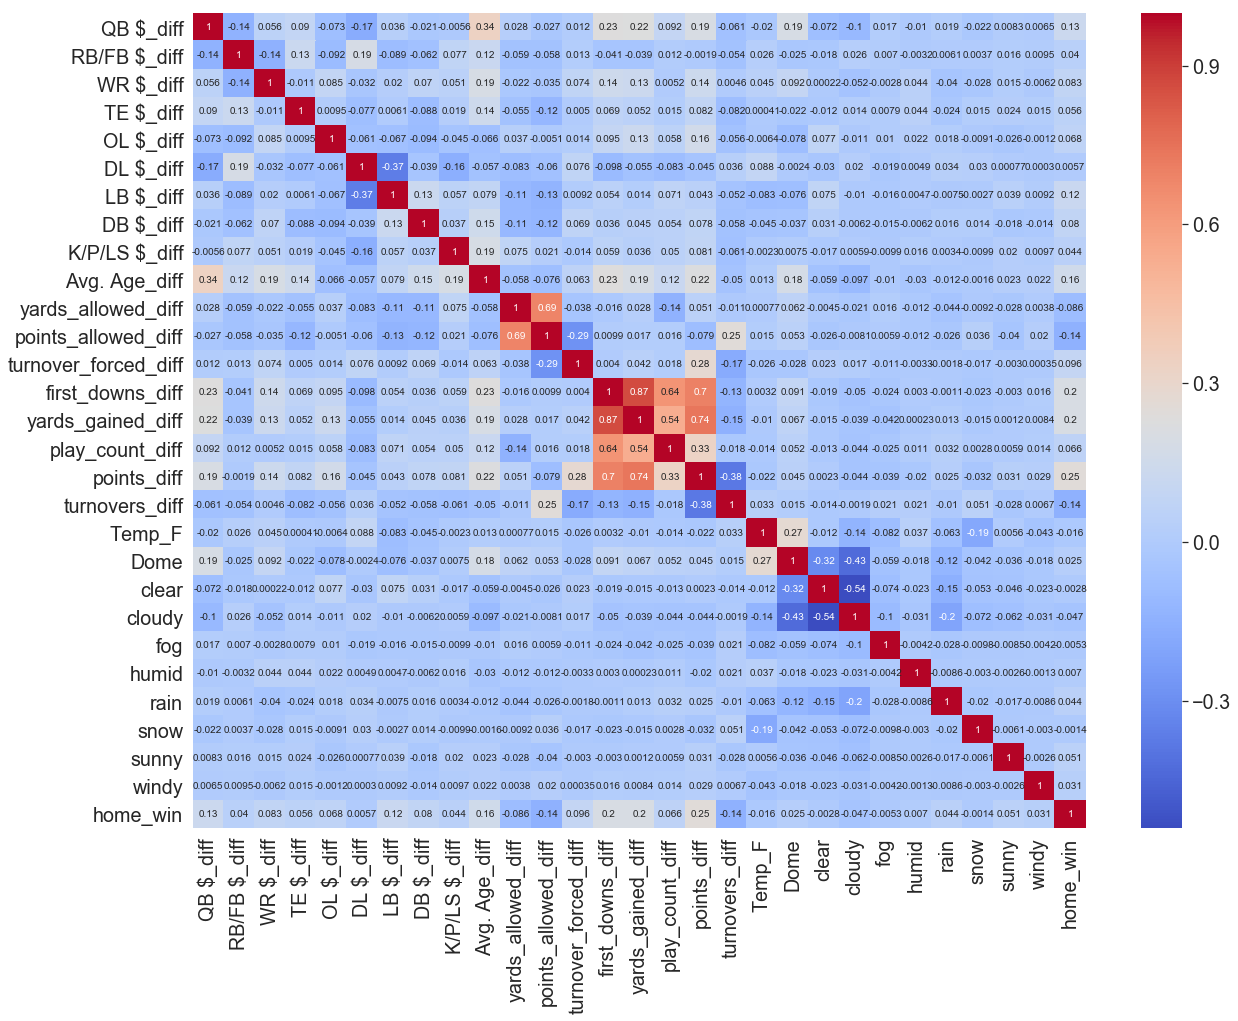

In [699]:
sns.set(rc={'figure.figsize':(20,15)}, font_scale=3)
sns.set(font_scale=1.8)
sns.heatmap(games[for_corr].corr(),cmap='coolwarm',annot=True, annot_kws={"size": 10})

In [700]:
#Principal Component Analysis
from sklearn.preprocessing import StandardScaler

In [701]:
scaler = StandardScaler()
scaler.fit(past_games[training_cols])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [702]:
scaled_data = scaler.transform(past_games[training_cols])

In [703]:
from sklearn.decomposition import PCA

In [704]:
pca = PCA(n_components=2)

In [705]:
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [706]:
x_pca = pca.transform(scaled_data)

In [707]:
scaled_data.shape

(1920L, 28L)

In [708]:
x_pca.shape

(1920L, 2L)

Text(0,0.5,'Second Principal Component')

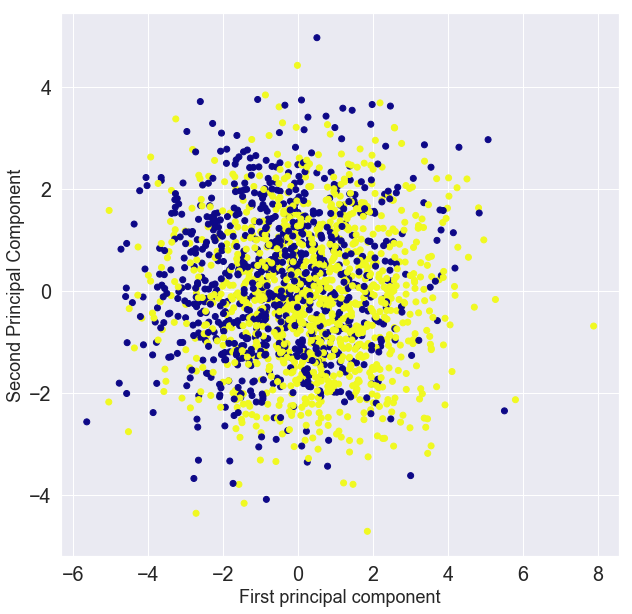

In [709]:
plt.figure(figsize=(10,10))
plt.scatter(x_pca[:,0],x_pca[:,1],c=past_games['home_win'],cmap='plasma')
plt.xlabel('First principal component', fontsize=18)
plt.ylabel('Second Principal Component', fontsize=18)

In [710]:
pca.components_

array([[ 2.00699964e-01, -2.74125140e-02,  1.14859849e-01,
         4.53288782e-02,  5.81958630e-02, -1.02024550e-01,
         7.25720863e-02,  6.55314325e-02,  5.01477030e-02,
         2.22351021e-01, -3.75563762e-02, -6.74235226e-02,
         1.00754966e-01,  4.92996507e-01,  4.82428120e-01,
         3.49976454e-01,  4.57838206e-01, -1.74898149e-01,
         4.58580309e-03,  8.56025170e-02, -1.06130553e-02,
        -5.86383355e-02, -3.25929159e-02, -1.90709305e-02,
         1.37291602e-02, -2.79280741e-02,  1.59181190e-02,
         1.67953196e-02],
       [ 1.11648717e-01, -1.03292817e-01,  1.54738006e-02,
        -1.24749026e-01, -1.89573192e-02, -1.38087030e-01,
        -1.09468362e-01, -1.66492102e-01,  8.28759495e-02,
         3.74283285e-04,  5.02234231e-01,  5.95807062e-01,
        -2.86017662e-01,  9.33968378e-02,  8.32429559e-02,
         4.21873628e-02, -5.09727921e-02,  2.41378118e-01,
         1.13828099e-01,  2.79940538e-01, -3.69803013e-02,
        -1.60560175e-01,  1.69

In [711]:
df_comp = pd.DataFrame(pca.components_,columns=training_cols)

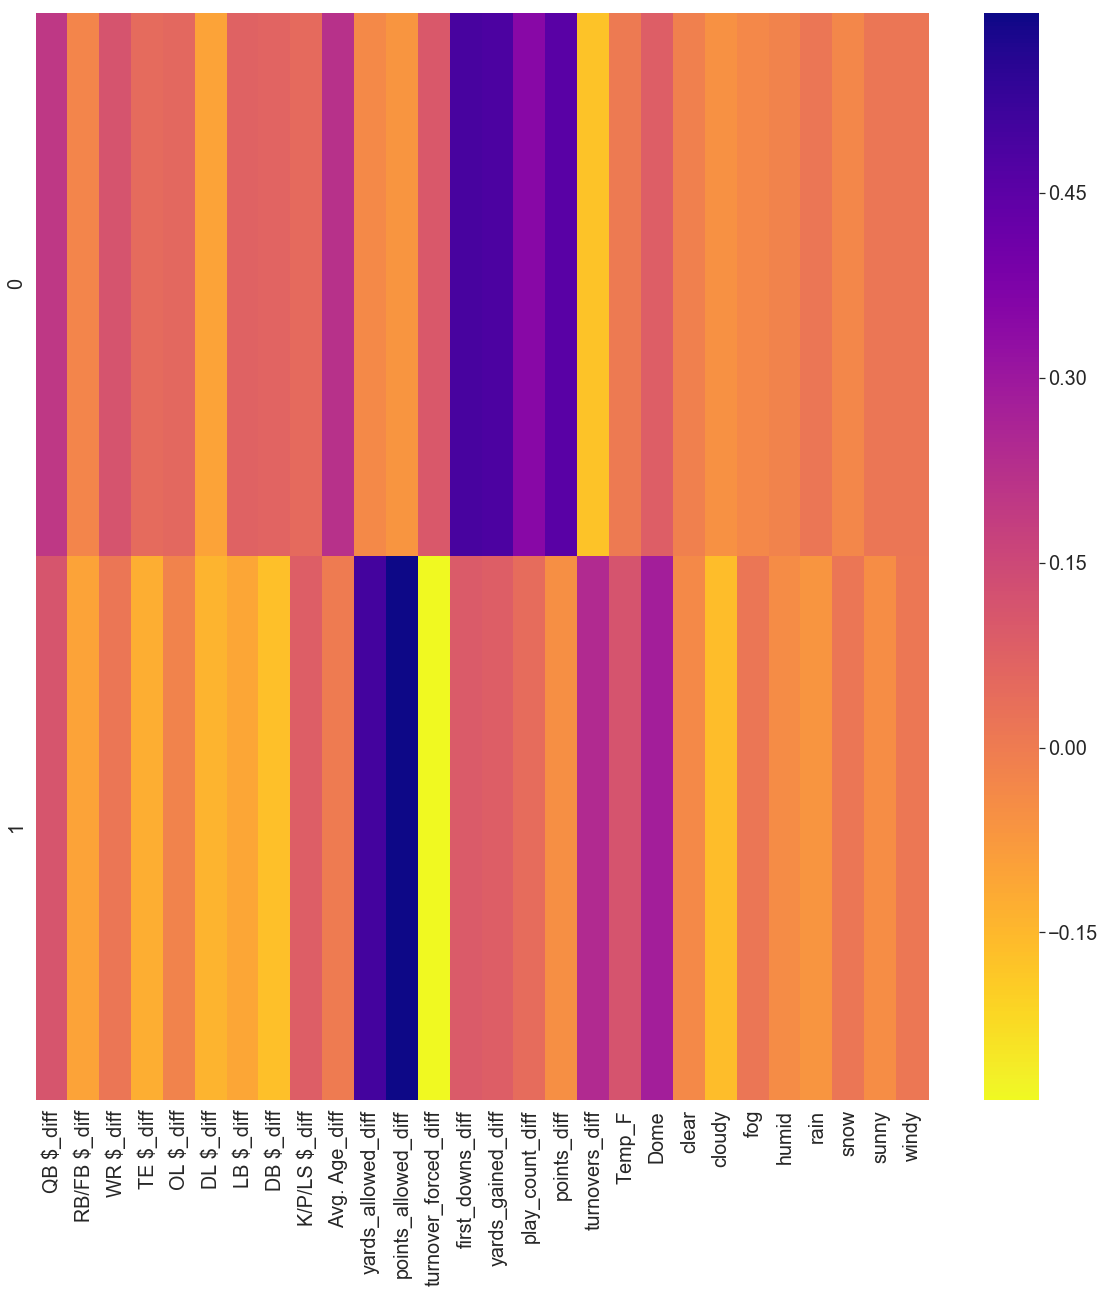

In [712]:
sns.set(rc={'figure.figsize':(20,20)}, font_scale=3)
sns.set(font_scale=1.8)
fig = sns.heatmap(df_comp,cmap='plasma_r').get_figure()
fig.savefig('PCA2.png')

In [713]:
past_games.head()

,year,week,home_team,home_score,away_team,away_score,home_win,away_win,tie,Temp_F,...,Avg. Age_diff,yards_allowed_diff,points_allowed_diff,turnover_forced_diff,first_downs_diff,yards_gained_diff,play_count_diff,points_diff,turnovers_diff,intercept
0,2010,3,ARI,24,OAK,23,1,0,0,70,...,0.32,130.0,-10.0,8.0,-15.0,-168.0,-68.0,22.0,-1.0,1.0
1,2010,5,ARI,30,NO,20,1,0,0,70,...,0.49,240.0,40.0,2.0,-23.0,-406.0,-70.0,-29.0,6.0,1.0
2,2010,8,ARI,35,TB,38,0,1,0,70,...,2.18,98.0,34.0,-4.0,-27.0,-512.0,-60.0,-16.0,6.0,1.0
3,2010,10,ARI,18,SEA,36,0,1,0,70,...,0.34,83.0,10.0,3.0,1.0,-44.0,-50.0,18.0,4.0,1.0
4,2010,12,ARI,6,SF,27,0,1,0,70,...,0.62,472.0,50.0,-1.0,8.0,-25.0,1.0,8.0,4.0,1.0


In [714]:
past_games.tail()

,year,week,home_team,home_score,away_team,away_score,home_win,away_win,tie,Temp_F,...,Avg. Age_diff,yards_allowed_diff,points_allowed_diff,turnover_forced_diff,first_downs_diff,yards_gained_diff,play_count_diff,points_diff,turnovers_diff,intercept
2042,2017,6,BAL,24,CHI,27,0,1,0,68,...,0.47,118.0,-20.0,9.0,-3.0,-53.0,8.0,8.0,0.0,1.0
2043,2017,2,BAL,24,CLE,10,1,0,0,78,...,2.30,55.0,-5.0,5.0,-3.0,226.0,24.0,22.0,3.0,1.0
2044,2017,4,BAL,9,PIT,26,0,1,0,64,...,0.20,230.0,11.0,6.0,-4.0,-134.0,7.0,-29.0,3.0,1.0
2045,2017,16,BAL,23,IND,16,1,0,0,61,...,1.09,-44.0,-21.0,4.0,28.0,410.0,23.0,78.0,-1.0,1.0
2046,2017,12,BAL,23,HOU,16,1,0,0,44,...,0.47,-422.0,-49.0,1.0,-12.0,-446.0,-11.0,-5.0,-2.0,1.0


In [715]:
future_games.head()

,year,week,home_team,home_score,away_team,away_score,home_win,away_win,tie,Temp_F,...,Avg. Age_diff,yards_allowed_diff,points_allowed_diff,turnover_forced_diff,first_downs_diff,yards_gained_diff,play_count_diff,points_diff,turnovers_diff,intercept
2047,2018,1,ARI,6,WAS,24,0,1,0,70,...,-0.32,-446.0,-29.0,1.0,25.0,135.0,73.0,9.0,-1.0,1.0
2048,2018,3,ARI,14,CHI,16,0,1,0,70,...,0.02,148.0,14.0,-1.0,-12.0,-180.0,-6.0,-2.0,1.0,1.0
2049,2018,4,ARI,17,SEA,20,0,1,0,70,...,0.13,174.0,0.0,-6.0,-6.0,-176.0,-44.0,-39.0,5.0,1.0
2050,2018,7,ARI,10,DEN,45,0,1,0,70,...,0.31,-187.0,-16.0,3.0,-46.0,-747.0,-59.0,-32.0,0.0,1.0
2051,2018,8,ARI,18,SF,15,1,0,0,70,...,0.49,-19.0,-44.0,4.0,-44.0,-648.0,-47.0,-36.0,0.0,1.0


In [716]:
future_games.tail()

,year,week,home_team,home_score,away_team,away_score,home_win,away_win,tie,Temp_F,...,Avg. Age_diff,yards_allowed_diff,points_allowed_diff,turnover_forced_diff,first_downs_diff,yards_gained_diff,play_count_diff,points_diff,turnovers_diff,intercept
2298,2018,13,NE,24,MIN,10,1,0,0,51,...,1.50,580.0,19.0,-2.0,12.0,296.0,28.0,-1.0,-3.0,1.0
2299,2018,4,NE,38,MIA,7,1,0,0,66,...,1.25,-50.0,-13.0,-4.0,24.0,-29.0,48.0,12.0,0.0,1.0
2300,2018,9,NE,31,GB,17,1,0,0,42,...,2.10,217.0,-11.0,4.0,13.0,-6.0,30.0,45.0,4.0,1.0
2301,2018,16,NE,24,BUF,12,1,0,0,37,...,1.10,521.0,16.0,-1.0,5.0,168.0,11.0,-14.0,-2.0,1.0
2302,2018,6,NE,43,KC,40,1,0,0,45,...,1.50,-490.0,-18.0,0.0,-17.0,-274.0,-24.0,-28.0,4.0,1.0


In [717]:
games_18.head()

,year,week,home_team,home_score,away_team,away_score,home_win,away_win,tie,Temp_F,...,QB $_diff,RB/FB $_diff,WR $_diff,TE $_diff,OL $_diff,DL $_diff,LB $_diff,DB $_diff,K/P/LS $_diff,Avg. Age_diff
2301,2018,1,ARI,6,WAS,24,0,1,0,70,...,3.018127e+05,112695.8125,9.069037e+05,139460.5000,-1.326177e+06,677969.0000,-6.397348e+05,125544.8750,15030.9375,-0.32
2302,2018,3,ARI,14,CHI,16,0,1,0,70,...,-3.374179e+05,209214.0625,-3.562994e+05,-33768.0000,-1.453810e+06,123663.9375,-1.067429e+06,305891.4375,-141750.9375,0.02
2303,2018,4,ARI,17,SEA,20,0,1,0,70,...,-1.205755e+06,100832.0625,1.055912e+05,349226.8750,-1.235906e+06,745288.0625,-7.475401e+05,800250.1250,29809.2500,0.13
2304,2018,7,ARI,10,DEN,45,0,1,0,70,...,-6.519005e+05,291858.5625,1.102337e+06,443451.4375,-6.951646e+05,171344.3750,-1.267921e+06,231805.3750,-51410.6250,0.31
2305,2018,8,ARI,18,SF,15,1,0,0,70,...,2.501461e+05,77208.1875,7.668109e+05,290562.2500,-1.946871e+06,114975.3125,1.852092e+05,813399.9375,33771.6875,0.49


In [718]:
games_18.tail()

,year,week,home_team,home_score,away_team,away_score,home_win,away_win,tie,Temp_F,...,QB $_diff,RB/FB $_diff,WR $_diff,TE $_diff,OL $_diff,DL $_diff,LB $_diff,DB $_diff,K/P/LS $_diff,Avg. Age_diff
2552,2018,13,NE,24,MIN,10,1,0,0,51,...,-2.216875e+05,36330.1875,-84056.6875,365640.8750,-341805.0625,-1.228295e+06,-1.869574e+05,3.117158e+05,289375.0000,1.50
2553,2018,4,NE,38,MIA,7,1,0,0,66,...,7.998959e+05,353606.1250,-371127.5625,755884.3125,-42011.6875,-1.326506e+06,1.067762e+05,1.356677e+06,385679.1875,1.25
2554,2018,9,NE,31,GB,17,1,0,0,42,...,5.269200e+04,478381.5000,-722575.8750,281106.8125,-892333.7500,8.989636e+05,3.038619e+04,1.751834e+06,98517.3125,2.10
2555,2018,16,NE,24,BUF,12,1,0,0,37,...,1.121379e+06,-300977.9375,691145.2500,289210.9375,367050.4375,-9.620651e+05,4.534702e+05,1.320781e+06,257481.6250,1.10
2556,2018,6,NE,43,KC,40,1,0,0,45,...,1.036366e+06,149244.1250,109311.3750,146347.8750,-673445.6875,1.418199e+05,-1.286141e+06,8.188676e+05,298437.5000,1.50


In [719]:
training_cols

['QB $_diff',
 'RB/FB $_diff',
 'WR $_diff',
 'TE $_diff',
 'OL $_diff',
 'DL $_diff',
 'LB $_diff',
 'DB $_diff',
 'K/P/LS $_diff',
 'Avg. Age_diff',
 'yards_allowed_diff',
 'points_allowed_diff',
 'turnover_forced_diff',
 'first_downs_diff',
 'yards_gained_diff',
 'play_count_diff',
 'points_diff',
 'turnovers_diff',
 'Temp_F',
 'Dome',
 'clear',
 'cloudy',
 'fog',
 'humid',
 'rain',
 'snow',
 'sunny',
 'windy']

In [720]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2303 entries, 0 to 2302
Data columns (total 37 columns):
year                    2303 non-null int64
week                    2303 non-null int64
home_team               2303 non-null object
home_score              2303 non-null int64
away_team               2303 non-null object
away_score              2303 non-null int64
home_win                2303 non-null int64
away_win                2303 non-null int64
tie                     2303 non-null int64
Temp_F                  2303 non-null int32
Dome                    2303 non-null uint8
clear                   2303 non-null uint8
cloudy                  2303 non-null uint8
fog                     2303 non-null uint8
humid                   2303 non-null uint8
rain                    2303 non-null uint8
snow                    2303 non-null uint8
sunny                   2303 non-null uint8
windy                   2303 non-null uint8
QB $_diff               2303 non-null float64
RB/FB $_d

In [721]:
# import logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# specify the alphas
param_grid = {'C': np.logspace(-5, 5, 15)}

# Instantiate a logistic regression classifier: logreg
logit = LogisticRegression()

# specify five-fold cross validation logistic regression while tuning over alpha space
logit_cv = GridSearchCV(logit, param_grid, cv=5)

# fit the model
#logit_cv.fit(past_games[training_cols],past_games['home_win'])
logit_cv.fit(past_games[training_cols],past_games['home_win'])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e-05, 5.17947e-05, 2.68270e-04, 1.38950e-03, 7.19686e-03,
       3.72759e-02, 1.93070e-01, 1.00000e+00, 5.17947e+00, 2.68270e+01,
       1.38950e+02, 7.19686e+02, 3.72759e+03, 1.93070e+04, 1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

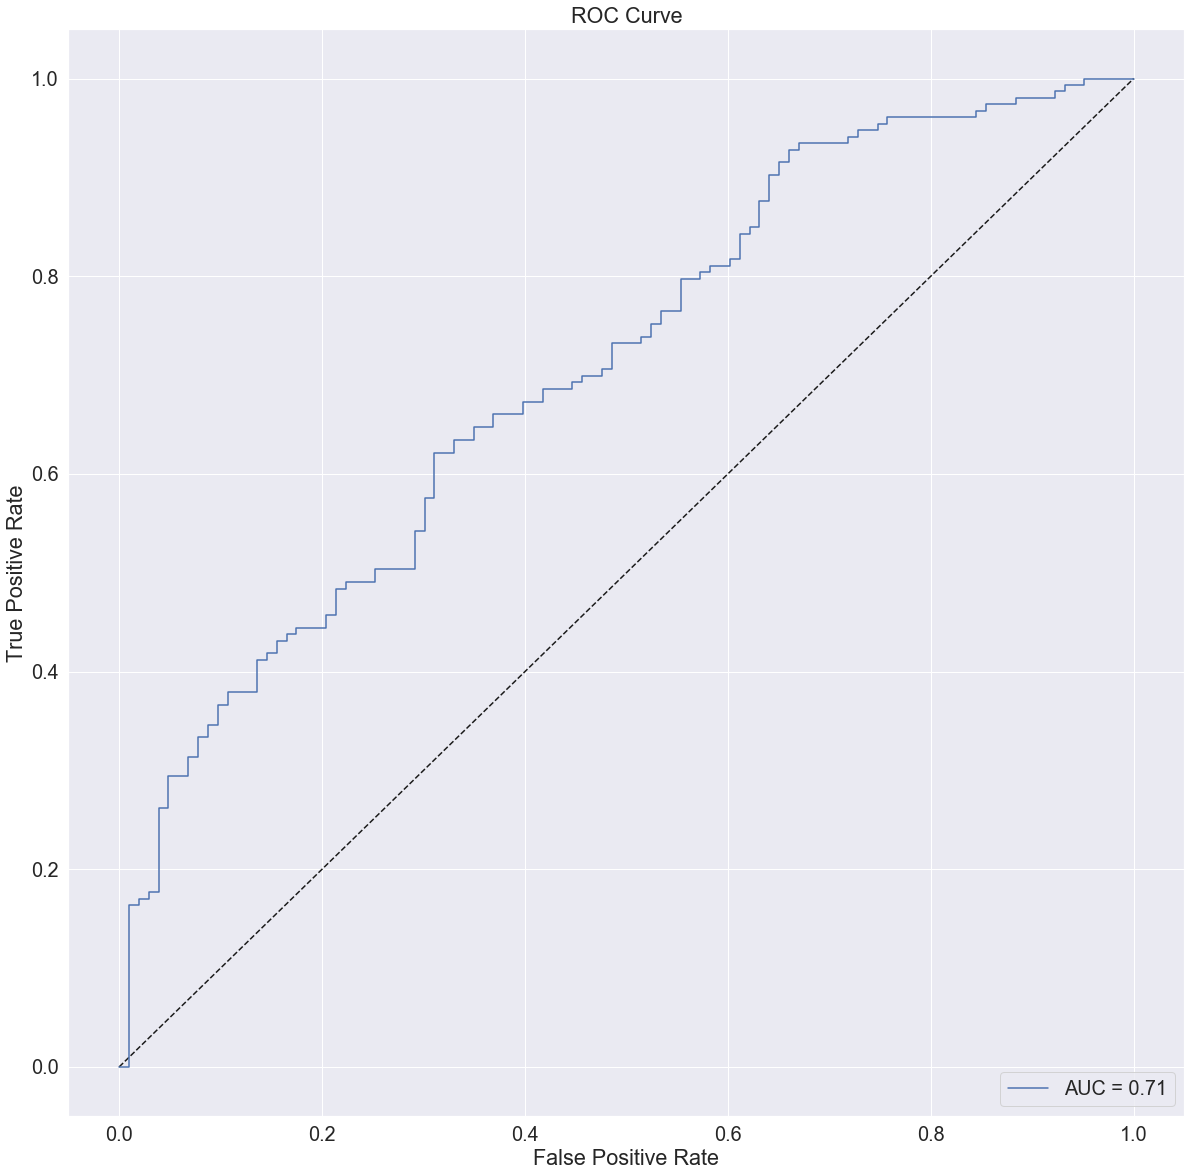

In [722]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logit_cv.predict_proba(future_games[training_cols])[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(future_games['home_win'], y_pred_prob)

#compute area under the curve
auc = metrics.auc(fpr,tpr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label="AUC = %0.2f" % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [723]:
# predict the results 
preds=logit_cv.predict(future_games[training_cols])



future_games['prediction'] = preds
future_games['pred_winner'] = np.where(future_games['prediction']==1,future_games['home_team'],future_games['away_team'])
future_games['actual_winner'] = np.where(future_games['home_win']==1,future_games['home_team'],future_games['away_team'])
future_games['Home Win Probabiltiy %'] = logit_cv.predict_proba(future_games[training_cols])[:,1]*100.00


logit_future_games = future_games[['year','week','home_team','away_team','Home Win Probabiltiy %','pred_winner','actual_winner']].sort_values(['week'])

logit_future_games['cum_pred_home_wins'] = (logit_future_games['pred_winner'] == logit_future_games['home_team'])*1
logit_future_games['Cumulative Predicted Home Wins'] = logit_future_games.groupby('home_team').cum_pred_home_wins.cumsum()

logit_future_games['act_pred_home_wins'] = (logit_future_games['actual_winner'] == logit_future_games['home_team'])*1
logit_future_games['Cumulative Actual Home Wins'] = logit_future_games.groupby('home_team').act_pred_home_wins.cumsum()

logit_future_games = logit_future_games.drop(columns = ['cum_pred_home_wins','act_pred_home_wins'])

items = sorted(future_games['week'].unique().tolist())

def view(Week):
    display(logit_future_games[logit_future_games['week'] == Week])

w = widgets.Dropdown(options=items)
logit_plot = interact(view, Week=w)



aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnV2VlaycsIG9wdGlvbnM9KDFMLCAyTCwgM0wsIDRMLCA1TCwgNkwsIDdMLCA4TCwgOUwsIDEwTCwgMTFMLCAxMkzigKY=


In [724]:
#Predictions are the columns
#Actual is the rows
print(classification_report(future_games['home_win'],preds))

              precision    recall  f1-score   support

           0       0.55      0.50      0.52       103
           1       0.68      0.73      0.71       153

   micro avg       0.64      0.64      0.64       256
   macro avg       0.62      0.61      0.61       256
weighted avg       0.63      0.64      0.63       256



In [725]:
print(confusion_matrix(future_games['home_win'],preds))

[[ 51  52]
 [ 41 112]]


In [726]:
#SVM Model
from sklearn.svm import SVC 
svc_model = SVC(probability=True)
svc_model.fit(past_games[training_cols],past_games['home_win'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [727]:
#Model Evaluation
predictions = svc_model.predict(future_games[training_cols])

In [728]:
print(confusion_matrix(future_games['home_win'], predictions))

[[  0 103]
 [  0 153]]


In [729]:
print(classification_report(future_games['home_win'], predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       103
           1       0.60      1.00      0.75       153

   micro avg       0.60      0.60      0.60       256
   macro avg       0.30      0.50      0.37       256
weighted avg       0.36      0.60      0.45       256



In [730]:
#Gridsearch
param_grid = {'C': np.logspace(-5, 5, 15)} 
grid = GridSearchCV(SVC(probability=True), param_grid, refit=True, verbose=3)

In [731]:
grid.fit(past_games[training_cols], past_games['home_win'])

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] C=1e-05 .........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... C=1e-05, score=0.563182527301, total=   0.9s
[CV] C=1e-05 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] ......................... C=1e-05, score=0.5640625, total=   1.0s
[CV] C=1e-05 .........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


[CV] ..................... C=1e-05, score=0.56338028169, total=   0.9s
[CV] C=5.1794746792312125e-05 ........................................
[CV] ... C=5.1794746792312125e-05, score=0.563182527301, total=   1.6s
[CV] C=5.1794746792312125e-05 ........................................
[CV] ........ C=5.1794746792312125e-05, score=0.5640625, total=   1.4s
[CV] C=5.1794746792312125e-05 ........................................
[CV] .... C=5.1794746792312125e-05, score=0.56338028169, total=   1.6s
[CV] C=0.0002682695795279727 .........................................
[CV] .... C=0.0002682695795279727, score=0.563182527301, total=   1.4s
[CV] C=0.0002682695795279727 .........................................
[CV] ......... C=0.0002682695795279727, score=0.5640625, total=   1.0s
[CV] C=0.0002682695795279727 .........................................
[CV] ..... C=0.0002682695795279727, score=0.56338028169, total=   0.9s
[CV] C=0.0013894954943731374 .........................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.3min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e-05, 5.17947e-05, 2.68270e-04, 1.38950e-03, 7.19686e-03,
       3.72759e-02, 1.93070e-01, 1.00000e+00, 5.17947e+00, 2.68270e+01,
       1.38950e+02, 7.19686e+02, 3.72759e+03, 1.93070e+04, 1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [732]:
grid.best_params_

{'C': 1e-05}

In [733]:
grid.best_estimator_

SVC(C=1e-05, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

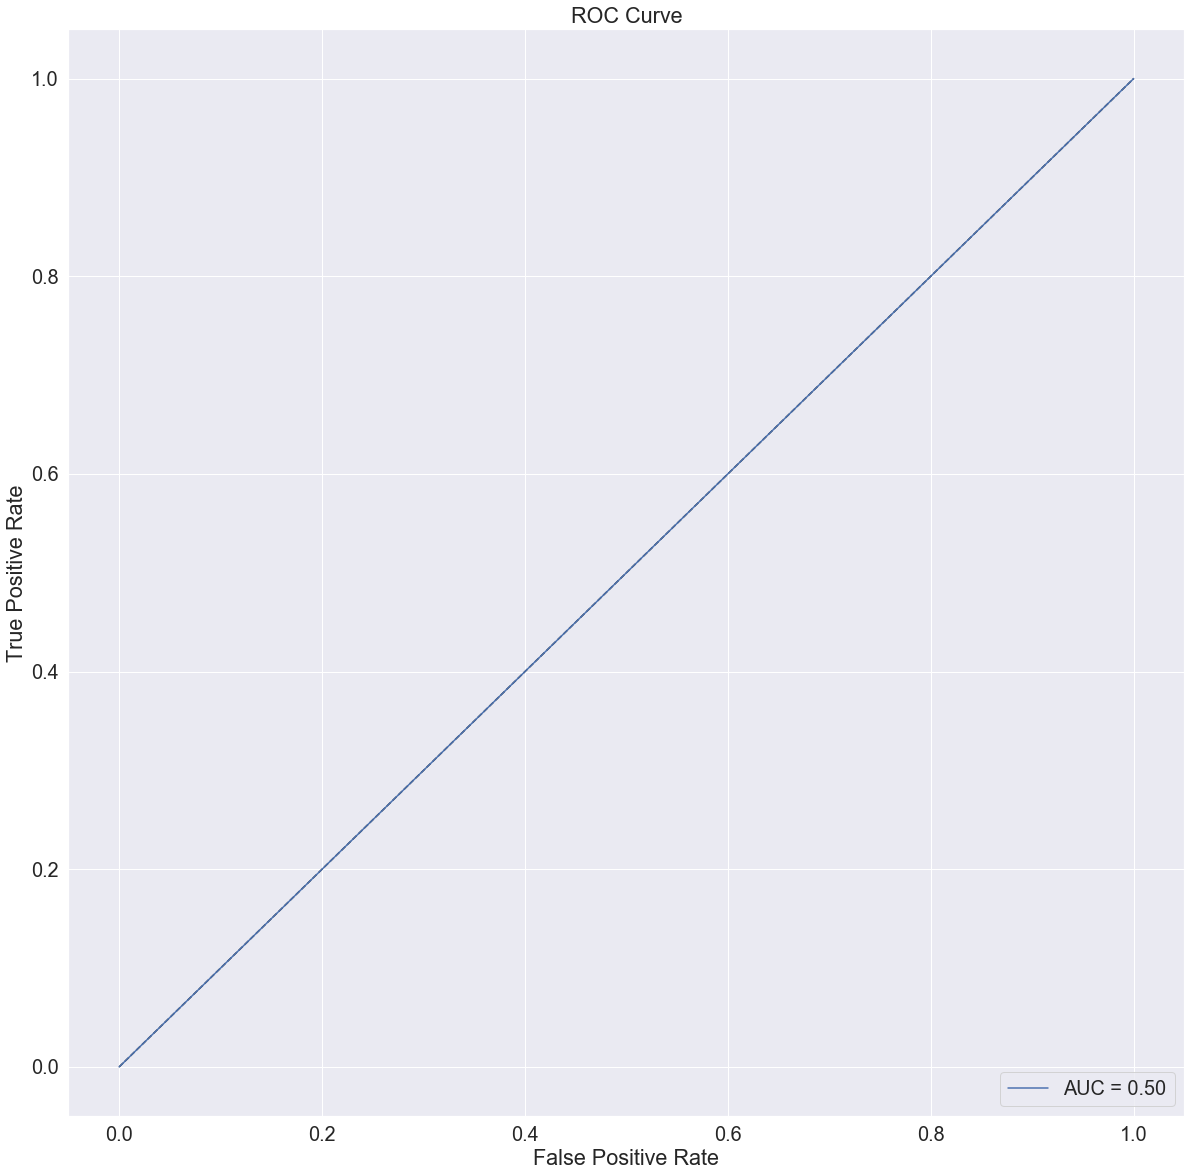

In [734]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob_svm = grid.predict_proba(future_games[training_cols])[:,1]


# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(future_games['home_win'], y_pred_prob_svm)

#compute area under the curve
auc = metrics.auc(fpr,tpr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label="AUC = %0.2f" % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [735]:
preds=grid.predict(future_games[training_cols])


future_games['prediction'] = preds
future_games['pred_winner'] = np.where(future_games['prediction']==1,future_games['home_team'],future_games['away_team'])
future_games['actual_winner'] = np.where(future_games['home_win']==1,future_games['home_team'],future_games['away_team'])
future_games['Home Win Probabiltiy %'] = grid.predict_proba(future_games[training_cols])[:,1]*100

svc_future_games = future_games[['year','week','home_team','away_team','Home Win Probabiltiy %','pred_winner','actual_winner']].sort_values(['week'])

svc_future_games['cum_pred_home_wins'] = (svc_future_games['pred_winner'] == svc_future_games['home_team'])*1
svc_future_games['Cumulative Predicted Home Wins'] = svc_future_games.groupby('home_team').cum_pred_home_wins.cumsum()

svc_future_games['act_pred_home_wins'] = (svc_future_games['actual_winner'] == svc_future_games['home_team'])*1
svc_future_games['Cumulative Actual Home Wins'] = svc_future_games.groupby('home_team').act_pred_home_wins.cumsum()

svc_future_games = svc_future_games.drop(columns = ['cum_pred_home_wins','act_pred_home_wins'])



items = sorted(future_games['week'].unique().tolist())

#items[0] = 'Select Week'



def view(Week):
    display(svc_future_games[svc_future_games['week'] == Week])

w = widgets.Dropdown(options=items)
svc_plot = interact(view, Week=w)


aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnV2VlaycsIG9wdGlvbnM9KDFMLCAyTCwgM0wsIDRMLCA1TCwgNkwsIDdMLCA4TCwgOUwsIDEwTCwgMTFMLCAxMkzigKY=


In [736]:
print(classification_report(future_games['home_win'], predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       103
           1       0.60      1.00      0.75       153

   micro avg       0.60      0.60      0.60       256
   macro avg       0.30      0.50      0.37       256
weighted avg       0.36      0.60      0.45       256



In [737]:
print(confusion_matrix(future_games['home_win'], predictions))

[[  0 103]
 [  0 153]]


In [738]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()

In [739]:
dtree.fit(past_games[training_cols], past_games['home_win'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

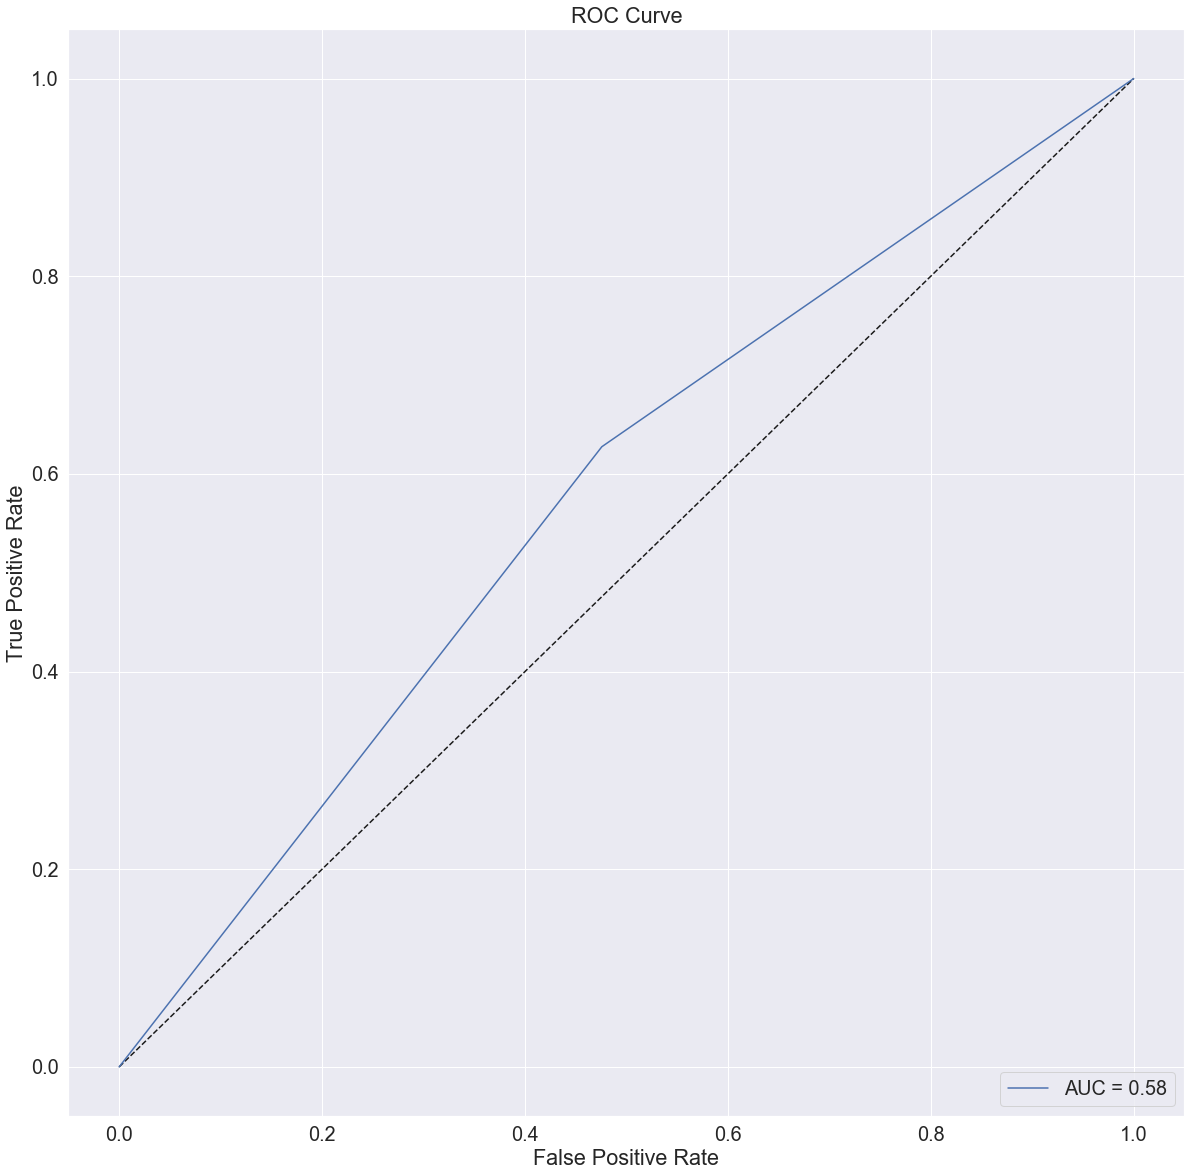

In [740]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob_dtree = dtree.predict_proba(future_games[training_cols])[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(future_games['home_win'], y_pred_prob_dtree)

#compute area under the curve
auc = metrics.auc(fpr,tpr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label="AUC = %0.2f" % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [741]:
predictions = dtree.predict(future_games[training_cols])

In [742]:

future_games['prediction'] = predictions
future_games['pred_winner'] = np.where(future_games['prediction']==1,future_games['home_team'],future_games['away_team'])
future_games['actual_winner'] = np.where(future_games['home_win']==1,future_games['home_team'],future_games['away_team'])
future_games['Home Win Probabiltiy %'] = dtree.predict_proba(future_games[training_cols])[:,1]

dtree_future_games = future_games[['year','week','home_team','away_team','Home Win Probabiltiy %','pred_winner','actual_winner']].sort_values(['week'])

dtree_future_games['cum_pred_home_wins'] = (dtree_future_games['pred_winner'] == dtree_future_games['home_team'])*1
dtree_future_games['Cumulative Predicted Home Wins'] = dtree_future_games.groupby('home_team').cum_pred_home_wins.cumsum()

dtree_future_games['act_pred_home_wins'] = (dtree_future_games['actual_winner'] == dtree_future_games['home_team'])*1
dtree_future_games['Cumulative Actual Home Wins'] = dtree_future_games.groupby('home_team').act_pred_home_wins.cumsum()

dtree_future_games = dtree_future_games.drop(columns = ['cum_pred_home_wins','act_pred_home_wins'])



items = sorted(future_games['week'].unique().tolist())

#items[0] = 'Select Week'



def view(Week):
    display(dtree_future_games[dtree_future_games['week'] == Week])

w = widgets.Dropdown(options=items)
dtree_plot = interact(view, Week=w)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnV2VlaycsIG9wdGlvbnM9KDFMLCAyTCwgM0wsIDRMLCA1TCwgNkwsIDdMLCA4TCwgOUwsIDEwTCwgMTFMLCAxMkzigKY=


In [743]:
from sklearn.metrics import classification_report,confusion_matrix

In [744]:
print(classification_report(future_games['home_win'], predictions))

              precision    recall  f1-score   support

           0       0.49      0.52      0.50       103
           1       0.66      0.63      0.64       153

   micro avg       0.59      0.59      0.59       256
   macro avg       0.57      0.58      0.57       256
weighted avg       0.59      0.59      0.59       256



In [745]:
print(confusion_matrix(future_games['home_win'], predictions))

[[54 49]
 [57 96]]


In [746]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

features = training_cols



In [ ]:
dot_data = StringIO()  
export_graphviz(dtree, out_file=dot_data,feature_names=features,filled=True,rounded=True)

(graph,) = pydot.graph_from_dot_data(dot_data.getvalue())  
tree_fig = Image(graph.create_png())
graph.write_png('tree_fig.png')

In [ ]:
tree_fig

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(past_games[training_cols], past_games['home_win'])

In [ ]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob_rfc = rfc.predict_proba(future_games[training_cols])[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(future_games['home_win'], y_pred_prob_rfc)

#compute area under the curve
auc = metrics.auc(fpr,tpr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label="AUC = %0.2f" % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
rfc_pred = rfc.predict(future_games[training_cols])

In [ ]:

future_games['prediction'] = rfc_pred
future_games['pred_winner'] = np.where(future_games['prediction']==1,future_games['home_team'],future_games['away_team'])
future_games['actual_winner'] = np.where(future_games['home_win']==1,future_games['home_team'],future_games['away_team'])
future_games['Home Win Probability %'] = rfc.predict_proba(future_games[training_cols])[:,1]

rfc_future_games = future_games[['year','week','home_team','away_team','Home Win Probabiltiy %','pred_winner','actual_winner']].sort_values(['week'])

rfc_future_games['cum_pred_home_wins'] = (rfc_future_games['pred_winner'] == rfc_future_games['home_team'])*1
rfc_future_games['Cumulative Predicted Home Wins'] = rfc_future_games.groupby('home_team').cum_pred_home_wins.cumsum()

rfc_future_games['act_pred_home_wins'] = (rfc_future_games['actual_winner'] == rfc_future_games['home_team'])*1
rfc_future_games['Cumulative Actual Home Wins'] = rfc_future_games.groupby('home_team').act_pred_home_wins.cumsum()

rfc_future_games = rfc_future_games.drop(columns = ['cum_pred_home_wins','act_pred_home_wins'])


items = sorted(future_games['week'].unique().tolist())

#items[0] = 'Select Week'



def view(Week):
    display(rfc_future_games[rfc_future_games['week'] == Week])

w = widgets.Dropdown(options=items)
rfc_plot = interact(view, Week=w)

In [ ]:
print(confusion_matrix(future_games['home_win'],rfc_pred))

In [ ]:
print(classification_report(future_games['home_win'],rfc_pred))